In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    cohen_kappa_score
)
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Load the CSV file
# Now using relative path since we changed directory above
df = pd.read_csv('/content/drive/MyDrive/grp3_capstone/full_pipeline/ENGLISH_CERF_WORDS.csv', delimiter=',')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head(10)

Dataset shape: (9935, 2)

First few rows:


,headword,CEFR
0,a,A1
1,a.m./A.M./am/AM,A1
2,abandon,B1
3,abandoned,B2
4,ability,A2
5,able,B1
6,abnormal,B1
7,abnormally,B2
8,aboard,B1
9,abolish,B2


In [5]:
# Check data info
print("Dataset Information:")
print(df.info())
print("\nColumn names:", df.columns.tolist())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9935 entries, 0 to 9934
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headword  9935 non-null   object
 1   CEFR      9935 non-null   object
dtypes: object(2)
memory usage: 155.4+ KB
None

Column names: ['headword', 'CEFR']

Missing values:
headword    0
CEFR        0
dtype: int64


In [6]:
# Check CEFR level distribution
print("CEFR Level Distribution:")
print(df['CEFR'].value_counts().sort_index())
print("\nPercentage distribution:")
print(df['CEFR'].value_counts(normalize=True).sort_index() * 100)

CEFR Level Distribution:
CEFR
A1    1164
A2    1411
B1    2446
B2    2778
C1    1111
C2    1025
Name: count, dtype: int64

Percentage distribution:
CEFR
A1    11.716155
A2    14.202315
B1    24.620030
B2    27.961751
C1    11.182687
C2    10.317061
Name: proportion, dtype: float64


In [7]:
# Select relevant columns and remove any rows with missing CEFR levels
df_clean = df[['headword', 'CEFR']].copy()
df_clean = df_clean.dropna(subset=['CEFR', 'headword'])

# Remove any whitespace
df_clean['headword'] = df_clean['headword'].str.strip()
df_clean['CEFR'] = df_clean['CEFR'].str.strip()

# Filter only valid CEFR levels (A1, A2, B1, B2, C1, C2)
valid_levels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
df_clean = df_clean[df_clean['CEFR'].isin(valid_levels)]

print(f"Clean dataset shape: {df_clean.shape}")
print(f"\nCEFR distribution after cleaning:")
print(df_clean['CEFR'].value_counts().sort_index())

Clean dataset shape: (9935, 2)

CEFR distribution after cleaning:
CEFR
A1    1164
A2    1411
B1    2446
B2    2778
C1    1111
C2    1025
Name: count, dtype: int64


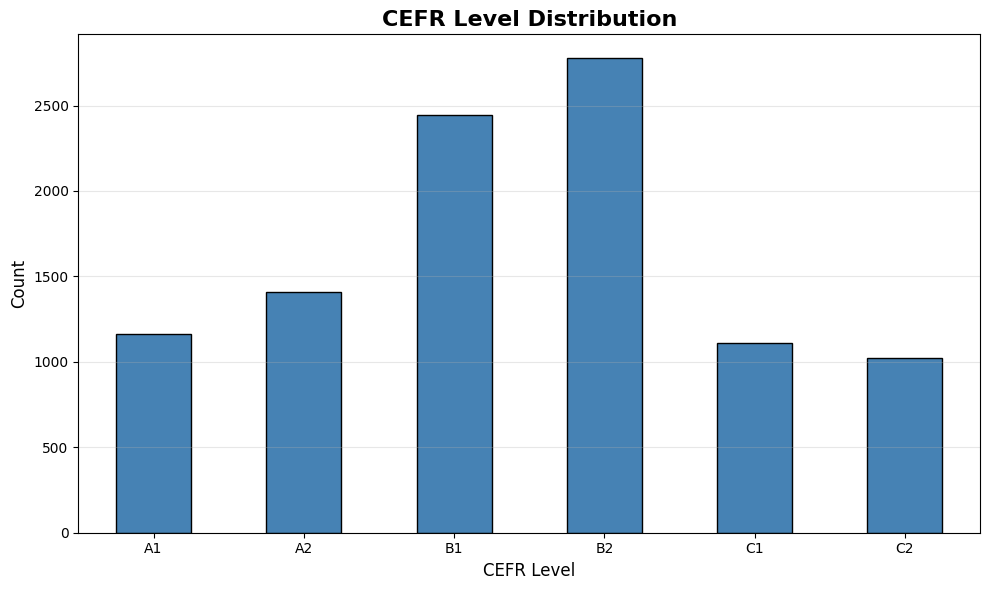


Total samples: 9935


In [8]:
# Visualize CEFR distribution
plt.figure(figsize=(10, 6))
df_clean['CEFR'].value_counts().sort_index().plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('CEFR Level Distribution', fontsize=16, fontweight='bold')
plt.xlabel('CEFR Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal samples: {len(df_clean)}")

In [9]:
# Extract character-level features from words
def extract_char_features(word):
    """Extract character-level n-grams from word"""
    word = word.lower()
    # Generate character n-grams (2-5)
    char_ngrams = []
    for n in range(2, 6):
        for i in range(len(word) - n + 1):
            char_ngrams.append(word[i:i+n])
    return ' '.join(char_ngrams)

# Apply character n-gram extraction
df_clean['char_features'] = df_clean['headword'].apply(extract_char_features)

print("Example word:", df_clean.iloc[10]['headword'])
print("Character n-grams:", df_clean.iloc[10]['char_features'][:100], "...")

Example word: aboriginal
Character n-grams: ab bo or ri ig gi in na al abo bor ori rig igi gin ina nal abor bori orig rigi igin gina inal abori  ...


In [10]:
# Prepare features (X) and labels (y)
X = df_clean['char_features'].values
y = df_clean['CEFR'].values

# Split data into training (80%) and testing (20%) sets
# Use stratify to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Training set size: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Testing set size: {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")
print(f"\nTraining set CEFR distribution:")
print(pd.Series(y_train).value_counts().sort_index())
print(f"\nTesting set CEFR distribution:")
print(pd.Series(y_test).value_counts().sort_index())

Training set size: 7948 (80.0%)
Testing set size: 1987 (20.0%)

Training set CEFR distribution:
A1     931
A2    1129
B1    1957
B2    2222
C1     889
C2     820
Name: count, dtype: int64

Testing set CEFR distribution:
A1    233
A2    282
B1    489
B2    556
C1    222
C2    205
Name: count, dtype: int64


In [11]:
# Initialize TF-IDF Vectorizer with specified parameters
# ngram_range=(2,5): Use character n-grams from 2 to 5
# min_df=1: Include all terms (no minimum document frequency)
vectorizer = TfidfVectorizer(
    ngram_range=(2, 5),
    min_df=1,
    analyzer='word',  # Analyze word tokens (which are our char n-grams)
    lowercase=False,  # Already lowercase
    max_features=10000  # Limit features to prevent memory issues
)

# Fit and transform training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform test data
X_test_tfidf = vectorizer.transform(X_test)

print(f"Training feature matrix shape: {X_train_tfidf.shape}")
print(f"Testing feature matrix shape: {X_test_tfidf.shape}")
print(f"\nNumber of features (character n-grams): {X_train_tfidf.shape[1]}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

Training feature matrix shape: (7948, 10000)
Testing feature matrix shape: (1987, 10000)

Number of features (character n-grams): 10000
Vocabulary size: 10000


In [12]:
# Initialize SGD Classifier with Logistic Regression loss
# loss='log_loss': Logistic regression
# alpha=1e-5: L2 regularization parameter
# max_iter=1000: Maximum number of epochs
# random_state=42: For reproducibility

model = SGDClassifier(
    loss='log_loss',  # Logistic regression
    alpha=1e-5,
    max_iter=1000,
    tol=1e-3,
    random_state=42,
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

print("Training SGD Logistic Regression model...")
print(f"Model parameters: {model.get_params()}\n")

# Train the model
model.fit(X_train_tfidf, y_train)

print("\n✓ Training completed!")

Training SGD Logistic Regression model...
Model parameters: {'alpha': 1e-05, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'log_loss', 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 1, 'warm_start': False}

-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
-- Epoch 1
Norm: 142.58, NNZs: 10000, Bias: -1.764765, T: 7948, Avg. loss: 0.651179
Total training time: 0.01 seconds.
Norm: 184.66, NNZs: 10000, Bias: -1.892722, T: 7948, Avg. loss: 1.347386
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 150.93, NNZs: 10000, Bias: -2.878814, T: 7948, Avg. loss: 0.851712
Total training time: 0.00 seconds.
-- Epoch 2
-- Epoch 2
Norm: 141.55, NNZs: 10000, Bias: -4.054996, T: 7948, Avg. loss: 0.631133
Total training time: 0.00 seconds.
-- Epo

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    0.1s finished


In [13]:
# Make predictions on both training and test sets
y_train_pred = model.predict(X_train_tfidf)
y_test_pred = model.predict(X_test_tfidf)

print("Predictions completed for both training and test sets.")

Predictions completed for both training and test sets.


In [14]:
# Calculate accuracy scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Calculate balanced accuracy (accounts for class imbalance)
train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test, y_test_pred)

# Calculate Cohen's Kappa (agreement score)
train_kappa = cohen_kappa_score(y_train, y_train_pred)
test_kappa = cohen_kappa_score(y_test, y_test_pred)

print("="*60)
print("OVERALL PERFORMANCE METRICS")
print("="*60)
print(f"\n{'Metric':<30} {'Training':<15} {'Testing'}")
print("-"*60)
print(f"{'Accuracy':<30} {train_accuracy:.4f} ({train_accuracy*100:.2f}%)  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'Balanced Accuracy':<30} {train_balanced_acc:.4f} ({train_balanced_acc*100:.2f}%)  {test_balanced_acc:.4f} ({test_balanced_acc*100:.2f}%)")
print(f"{'Cohen\'s Kappa':<30} {train_kappa:.4f}          {test_kappa:.4f}")
print("="*60)

OVERALL PERFORMANCE METRICS

Metric                         Training        Testing
------------------------------------------------------------
Accuracy                       0.7584 (75.84%)  0.3226 (32.26%)
Balanced Accuracy              0.7558 (75.58%)  0.3168 (31.68%)
Cohen's Kappa                  0.6984          0.1510


In [15]:
print("\n" + "="*60)
print("TRAINING SET - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_train, y_train_pred, digits=4))

print("\n" + "="*60)
print("TESTING SET - CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_test, y_test_pred, digits=4))


TRAINING SET - CLASSIFICATION REPORT
              precision    recall  f1-score   support

          A1     0.6897    0.7497    0.7185       931
          A2     0.7233    0.6413    0.6798      1129
          B1     0.7429    0.7588    0.7508      1957
          B2     0.7486    0.7921    0.7697      2222
          C1     0.8373    0.7930    0.8146       889
          C2     0.8829    0.8000    0.8394       820

    accuracy                         0.7584      7948
   macro avg     0.7708    0.7558    0.7621      7948
weighted avg     0.7605    0.7584    0.7585      7948


TESTING SET - CLASSIFICATION REPORT
              precision    recall  f1-score   support

          A1     0.2974    0.3433    0.3187       233
          A2     0.1841    0.1560    0.1689       282
          B1     0.2889    0.2883    0.2886       489
          B2     0.3543    0.4047    0.3778       556
          C1     0.3958    0.3423    0.3671       222
          C2     0.4573    0.3659    0.4065       205

  

In [16]:
# Get per-class metrics
precision_train, recall_train, f1_train, support_train = precision_recall_fscore_support(
    y_train, y_train_pred, labels=sorted(np.unique(y_train))
)
precision_test, recall_test, f1_test, support_test = precision_recall_fscore_support(
    y_test, y_test_pred, labels=sorted(np.unique(y_test))
)

# Create summary DataFrame
classes = sorted(np.unique(y_train))
metrics_df = pd.DataFrame({
    'CEFR Level': classes,
    'Train Precision': precision_train,
    'Train Recall': recall_train,
    'Train F1-Score': f1_train,
    'Train Support': support_train,
    'Test Precision': precision_test,
    'Test Recall': recall_test,
    'Test F1-Score': f1_test,
    'Test Support': support_test
})

print("\n" + "="*100)
print("PER-CLASS PERFORMANCE METRICS")
print("="*100)
print(metrics_df.to_string(index=False))
print("="*100)


PER-CLASS PERFORMANCE METRICS
CEFR Level  Train Precision  Train Recall  Train F1-Score  Train Support  Test Precision  Test Recall  Test F1-Score  Test Support
        A1         0.689723      0.749731        0.718477            931        0.297398     0.343348       0.318725           233
        A2         0.723277      0.641275        0.679812           1129        0.184100     0.156028       0.168906           282
        B1         0.742871      0.758815        0.750758           1957        0.288934     0.288344       0.288639           489
        B2         0.748618      0.792079        0.769735           2222        0.354331     0.404676       0.377834           556
        C1         0.837292      0.793026        0.814558            889        0.395833     0.342342       0.367150           222
        C2         0.882907      0.800000        0.839411            820        0.457317     0.365854       0.406504           205


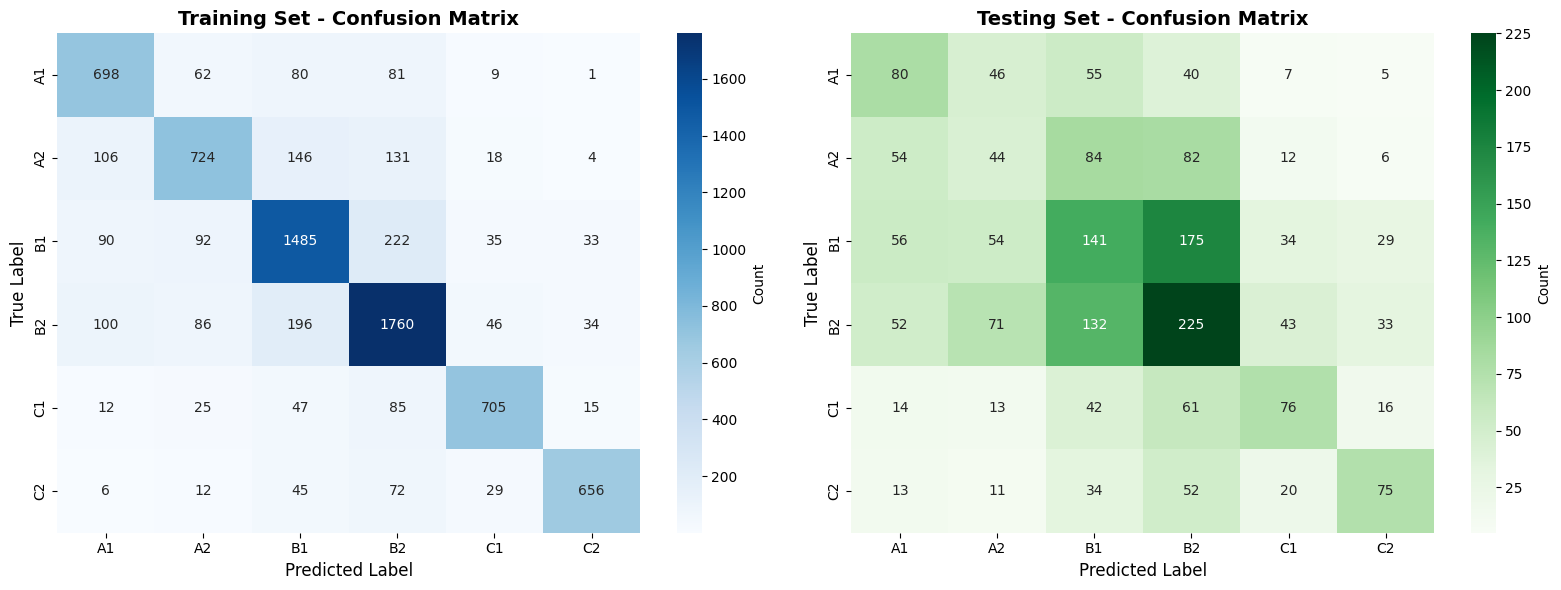

In [17]:
# Compute confusion matrices
cm_train = confusion_matrix(y_train, y_train_pred, labels=classes)
cm_test = confusion_matrix(y_test, y_test_pred, labels=classes)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set confusion matrix
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title('Training Set - Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Testing set confusion matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=classes, yticklabels=classes, ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title('Testing Set - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

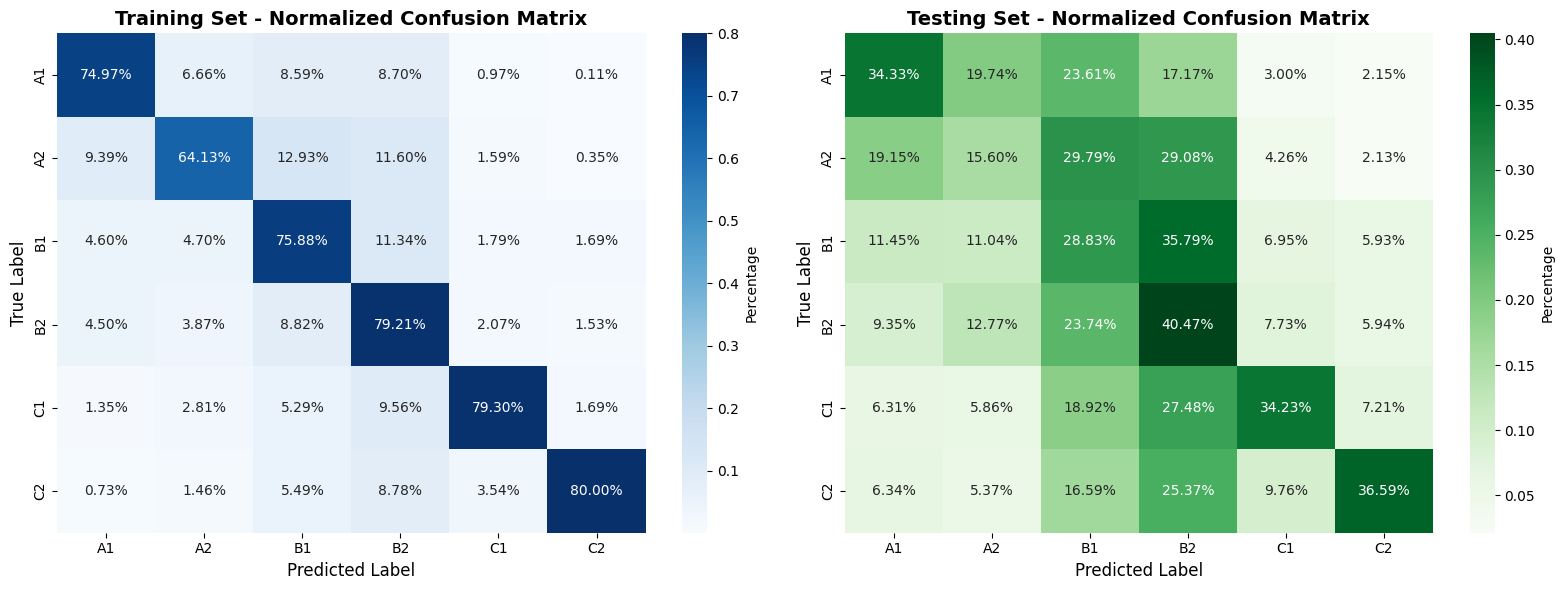

In [18]:
# Normalize confusion matrices
cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Training set normalized
sns.heatmap(cm_train_norm, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=classes, yticklabels=classes, ax=axes[0], cbar_kws={'label': 'Percentage'})
axes[0].set_title('Training Set - Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# Testing set normalized
sns.heatmap(cm_test_norm, annot=True, fmt='.2%', cmap='Greens',
            xticklabels=classes, yticklabels=classes, ax=axes[1], cbar_kws={'label': 'Percentage'})
axes[1].set_title('Testing Set - Normalized Confusion Matrix', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

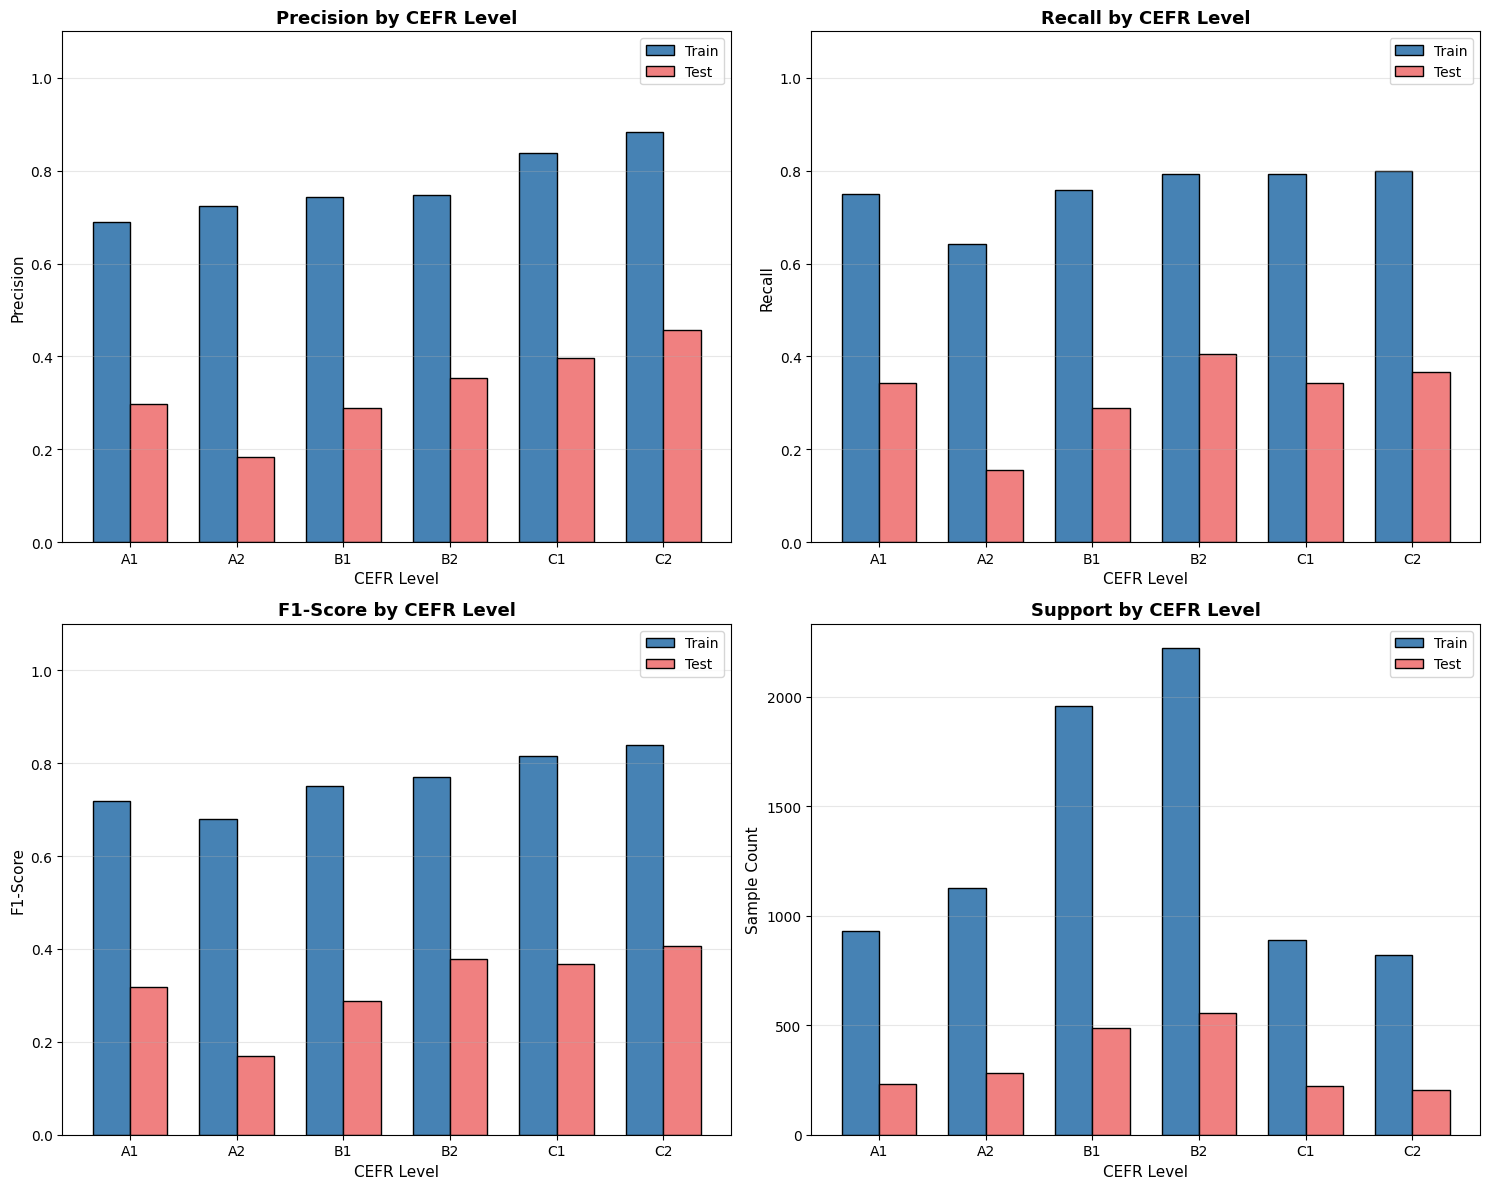

In [19]:
# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Precision comparison
x = np.arange(len(classes))
width = 0.35
axes[0, 0].bar(x - width/2, precision_train, width, label='Train', color='steelblue', edgecolor='black')
axes[0, 0].bar(x + width/2, precision_test, width, label='Test', color='lightcoral', edgecolor='black')
axes[0, 0].set_xlabel('CEFR Level', fontsize=11)
axes[0, 0].set_ylabel('Precision', fontsize=11)
axes[0, 0].set_title('Precision by CEFR Level', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(classes)
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].set_ylim([0, 1.1])

# Plot 2: Recall comparison
axes[0, 1].bar(x - width/2, recall_train, width, label='Train', color='steelblue', edgecolor='black')
axes[0, 1].bar(x + width/2, recall_test, width, label='Test', color='lightcoral', edgecolor='black')
axes[0, 1].set_xlabel('CEFR Level', fontsize=11)
axes[0, 1].set_ylabel('Recall', fontsize=11)
axes[0, 1].set_title('Recall by CEFR Level', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(classes)
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].set_ylim([0, 1.1])

# Plot 3: F1-Score comparison
axes[1, 0].bar(x - width/2, f1_train, width, label='Train', color='steelblue', edgecolor='black')
axes[1, 0].bar(x + width/2, f1_test, width, label='Test', color='lightcoral', edgecolor='black')
axes[1, 0].set_xlabel('CEFR Level', fontsize=11)
axes[1, 0].set_ylabel('F1-Score', fontsize=11)
axes[1, 0].set_title('F1-Score by CEFR Level', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_ylim([0, 1.1])

# Plot 4: Support (sample counts)
axes[1, 1].bar(x - width/2, support_train, width, label='Train', color='steelblue', edgecolor='black')
axes[1, 1].bar(x + width/2, support_test, width, label='Test', color='lightcoral', edgecolor='black')
axes[1, 1].set_xlabel('CEFR Level', fontsize=11)
axes[1, 1].set_ylabel('Sample Count', fontsize=11)
axes[1, 1].set_title('Support by CEFR Level', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(classes)
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get model coefficients for each class
coefficients = model.coef_

print(f"Model has {coefficients.shape[0]} classes and {coefficients.shape[1]} features")
print(f"\nTop 10 most important features for each CEFR level:\n")

for i, cefr_level in enumerate(model.classes_):
    print(f"\n{cefr_level}:")
    print("-" * 40)
    # Get top 10 features with highest positive coefficients
    top_indices = np.argsort(coefficients[i])[-10:][::-1]
    for idx in top_indices:
        print(f"  {feature_names[idx]:<20} (coef: {coefficients[i][idx]:.4f})")

Model has 6 classes and 10000 features

Top 10 most important features for each CEFR level:


A1:
----------------------------------------
  fa as                (coef: 4.6796)
  we er                (coef: 4.4230)
  mo om                (coef: 4.2249)
  fa am                (coef: 4.0415)
  ir rt                (coef: 4.0408)
  so on                (coef: 3.9051)
  ho os                (coef: 3.8891)
  ai ir                (coef: 3.5158)
  oo ok                (coef: 3.4735)
  on nl                (coef: 3.4646)

A2:
----------------------------------------
  nl li                (coef: 5.8178)
  fr ri                (coef: 5.6200)
  st sto               (coef: 5.2901)
  rw wa                (coef: 4.9463)
  ep pl                (coef: 4.5898)
  ch ha ai             (coef: 4.3857)
  ca ap                (coef: 4.3801)
  ha ap                (coef: 4.3228)
  du uc                (coef: 4.2566)
  tal al               (coef: 4.0334)

B1:
----------------------------------------
  ck kn  

In [21]:
# Test with some example words
example_words = ['hello', 'magnificent', 'unprecedented', 'cat', 'philosophy', 'run']

print("\n" + "="*60)
print("EXAMPLE PREDICTIONS")
print("="*60)

for word in example_words:
    # Extract features
    char_feat = extract_char_features(word)
    word_tfidf = vectorizer.transform([char_feat])

    # Predict
    prediction = model.predict(word_tfidf)[0]

    # Get decision function scores (confidence)
    decision_scores = model.decision_function(word_tfidf)[0]

    print(f"\nWord: '{word}'")
    print(f"  Predicted CEFR Level: {prediction}")
    print(f"  Decision scores:")
    for level, score in zip(model.classes_, decision_scores):
        print(f"    {level}: {score:.4f}")


EXAMPLE PREDICTIONS

Word: 'hello'
  Predicted CEFR Level: A1
  Decision scores:
    A1: 0.3439
    A2: -3.2985
    B1: -1.9485
    B2: -1.4226
    C1: -5.4025
    C2: -3.5425

Word: 'magnificent'
  Predicted CEFR Level: B1
  Decision scores:
    A1: -3.8088
    A2: -2.0644
    B1: -0.9126
    B2: -3.4589
    C1: -2.1148
    C2: -1.3295

Word: 'unprecedented'
  Predicted CEFR Level: B2
  Decision scores:
    A1: -2.7570
    A2: -1.9340
    B1: -4.3877
    B2: 1.3532
    C1: -3.8614
    C2: -2.9606

Word: 'cat'
  Predicted CEFR Level: A1
  Decision scores:
    A1: 1.9362
    A2: -4.1242
    B1: -4.0823
    B2: -2.1170
    C1: -2.5785
    C2: -4.3454

Word: 'philosophy'
  Predicted CEFR Level: B1
  Decision scores:
    A1: -3.5775
    A2: -2.9080
    B1: 1.4945
    B2: -1.4447
    C1: -4.4982
    C2: -3.3997

Word: 'run'
  Predicted CEFR Level: A1
  Decision scores:
    A1: 0.9267
    A2: -1.8091
    B1: -0.7374
    B2: -4.0582
    C1: -5.0415
    C2: -5.5155


In [22]:
print("\n" + "="*60)
print("MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: SGD Logistic Regression")
print(f"N-gram Range: (2, 5)")
print(f"Min DF: 1")
print(f"Alpha: 1e-5")
print(f"\nDataset:")
print(f"  Total samples: {len(df_clean)}")
print(f"  Training samples: {len(X_train)}")
print(f"  Testing samples: {len(X_test)}")
print(f"  Number of features: {X_train_tfidf.shape[1]}")
print(f"  Number of classes: {len(model.classes_)}")
print(f"  Classes: {', '.join(model.classes_)}")
print(f"\nPerformance:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Balanced Accuracy: {test_balanced_acc:.4f} ({test_balanced_acc*100:.2f}%)")
print(f"  Test Cohen's Kappa: {test_kappa:.4f}")
print(f"\nAverage Metrics (Test Set):")
print(f"  Precision: {np.mean(precision_test):.4f}")
print(f"  Recall: {np.mean(recall_test):.4f}")
print(f"  F1-Score: {np.mean(f1_test):.4f}")
print("="*60)


MODEL SUMMARY

Model Type: SGD Logistic Regression
N-gram Range: (2, 5)
Min DF: 1
Alpha: 1e-5

Dataset:
  Total samples: 9935
  Training samples: 7948
  Testing samples: 1987
  Number of features: 10000
  Number of classes: 6
  Classes: A1, A2, B1, B2, C1, C2

Performance:
  Test Accuracy: 0.3226 (32.26%)
  Test Balanced Accuracy: 0.3168 (31.68%)
  Test Cohen's Kappa: 0.1510

Average Metrics (Test Set):
  Precision: 0.3297
  Recall: 0.3168
  F1-Score: 0.3213


In [23]:
import pickle

# Save the trained model and vectorizer
model_data = {
    'model': model,
    'vectorizer': vectorizer,
    'classes': model.classes_,
    'feature_names': feature_names,
    'test_accuracy': test_accuracy,
    'test_balanced_accuracy': test_balanced_acc
}

with open('cefr_classifier_sgd.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ Model saved to 'cefr_classifier_sgd.pkl'")

✓ Model saved to 'cefr_classifier_sgd.pkl'


In [27]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.2 MB/s eta 0:00:00


In [28]:
# Install PyPDF2 if needed (uncomment if not installed)
# !pip install PyPDF2

import PyPDF2
import re
from collections import Counter

def extract_text_from_pdf(pdf_path):
    """Extract text from a PDF file"""
    with open(pdf_path, 'rb') as file:
        pdf_reader = PyPDF2.PdfReader(file)
        text = ""
        for page in pdf_reader.pages:
            text += page.extract_text()
    return text

def extract_words(text):
    """Extract words from text, removing punctuation and numbers"""
    # Convert to lowercase and extract words
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    return words

def annotate_words_with_cefr(words, model, vectorizer, extract_char_features):
    """Annotate words with their predicted CEFR levels"""
    unique_words = list(set(words))
    word_levels = {}

    for word in unique_words:
        # Extract features
        char_feat = extract_char_features(word)
        word_tfidf = vectorizer.transform([char_feat])

        # Predict
        prediction = model.predict(word_tfidf)[0]
        decision_scores = model.decision_function(word_tfidf)[0]
        confidence = max(decision_scores)

        word_levels[word] = {
            'level': prediction,
            'confidence': confidence
        }

    return word_levels

print("Functions defined for PDF processing and annotation.")

Functions defined for PDF processing and annotation.


In [32]:
# Load and process PDF transcript
# Update this path to your PDF file
pdf_path = '/content/drive/MyDrive/grp3_capstone/full_pipeline/pipeline1_outputs/english_transcript.txt'  # Change this to your PDF filename

try:
    # Read text directly from the .txt file
    print("Reading text from transcript file...")
    with open(pdf_path, 'r', encoding='utf-8') as file:
        transcript_text = file.read()

    print(f"✓ Extracted {len(transcript_text)} characters from transcript")
    print(f"\nFirst 500 characters:")
    print(transcript_text[:500])
    print("...")

except FileNotFoundError:
    print(f"❌ Error: Transcript file '{pdf_path}' not found.")
    print("Please update the 'pdf_path' variable with your transcript filename.")
    print("\nExample: pdf_path = 'my_transcript.txt'")
except Exception as e:
    print(f"❌ An unexpected error occurred: {e}")

Reading text from transcript file...
✓ Extracted 60569 characters from transcript

First 500 characters:
All right. Hey, everyone. Morning and welcome back. Um, so what I'd like to do today is, uh, continue our discussion of Naive Bayes and in particular, um, would describe how to use Naive Bayes, a generative learning algorithm to build a spam classifier that will almost work, right? And- and so, uh, today you see how the class moving is one other idea, uh, you need to add to the Naive Bayes algorithm we described on Monday to really make it work, um, for say email spam classification or- or for t
...


In [36]:
# Extract words from transcript
words = extract_words(transcript_text)

print(f"Total words extracted: {len(words)}")
print(f"Unique words: {len(set(words))}")
print(f"\nMost common words:")
word_freq = Counter(words)
for word, count in word_freq.most_common(20):
    print(f"  {word}: {count}")

Total words extracted: 11264
Unique words: 1163

Most common words:
  the: 538
  and: 358
  you: 319
  to: 286
  of: 282
  is: 276
  uh: 252
  a: 252
  so: 247
  um: 235
  this: 230
  that: 215
  right: 146
  i: 141
  s: 137
  in: 132
  it: 123
  we: 102
  know: 96
  if: 93


In [37]:
# Annotate words with CEFR levels
print("Annotating words with CEFR levels...")
word_annotations = annotate_words_with_cefr(words, model, vectorizer, extract_char_features)

print(f"✓ Annotated {len(word_annotations)} unique words")
print("\nSample annotations (first 20 alphabetically):")
print(f"\n{'Word':<20} {'CEFR Level':<12} {'Confidence'}")
print("-" * 50)
for word in sorted(word_annotations.keys())[:20]:
    info = word_annotations[word]
    print(f"{word:<20} {info['level']:<12} {info['confidence']:>10.4f}")

Annotating words with CEFR levels...
✓ Annotated 1163 unique words

Sample annotations (first 20 alphabetically):

Word                 CEFR Level   Confidence
--------------------------------------------------
a                    A1              -1.2654
able                 B1              -0.1043
about                A1              -0.1208
above                A1               0.1833
abrupt               B2               2.9567
absolute             B1               0.4960
absolutely           B1               0.4560
academic             B1               0.3826
according            B1               1.0322
accuracy             B1               1.6301
accurate             B1               0.2950
accurately           B1              -0.5622
achieve              B2               0.4410
actually             C2              -0.4369
add                  A1               0.6061
adding               B2               1.1398
address              B1              -0.0782
advanced             A2 

In [38]:
# Export annotated words to CSV
output_df = pd.DataFrame([
    {
        'word': word,
        'cefr_level': info['level'],
        'confidence': info['confidence'],
        'frequency': word_freq[word]
    }
    for word, info in word_annotations.items()
])

# Sort by frequency
output_df = output_df.sort_values('frequency', ascending=False)

# Save to CSV
output_filename = 'transcript_annotated_words.csv'
output_df.to_csv(output_filename, index=False)

print(f"✓ Annotated words saved to '{output_filename}'")
print(f"\nPreview of exported data:")
print(output_df.head(20))

✓ Annotated words saved to 'transcript_annotated_words.csv'

Preview of exported data:
      word cefr_level  confidence  frequency
442    the         A1    0.661818        538
202    and         A1    0.902456        358
30     you         A1    1.675114        319
957     to         A1   -1.265399        286
80      of         A1   -1.265399        282
176     is         A1   -1.265399        276
209     uh         A1   -1.265399        252
112      a         A1   -1.265399        252
479     so         A1   -1.265399        247
260     um         A1   -1.265399        235
141   this         A1    1.285967        230
101   that         A1    1.473701        215
375  right         A2   -0.387985        146
638      i         A1   -1.265399        141
33       s         A1   -1.265399        137
629     in         A1   -1.265399        132
50      it         A1   -1.265399        123
489     we         A1   -1.265399        102
353   know         A2   -0.323493         96
35      if   

In [39]:
# Calculate average difficulty of transcript
# Convert CEFR levels to numeric values (A1=1, A2=2, ..., C2=6)
level_to_num = {'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4, 'C1': 5, 'C2': 6}
num_to_level = {v: k for k, v in level_to_num.items()}

# Calculate weighted average based on word frequency
word_freq = Counter(words)
total_words = sum(word_freq.values())
weighted_sum = 0

for word, freq in word_freq.items():
    if word in word_annotations:
        level = word_annotations[word]['level']
        weighted_sum += level_to_num[level] * freq

average_difficulty = weighted_sum / total_words if total_words > 0 else 0

print("="*60)
print("TRANSCRIPT DIFFICULTY ANALYSIS")
print("="*60)
print(f"\nAverage CEFR difficulty: {average_difficulty:.2f}")
print(f"Approximate level: {num_to_level[round(average_difficulty)]}")
print(f"\nInterpretation:")
if average_difficulty < 2.5:
    print("  ✓ Beginner level (A1-A2) - Basic everyday vocabulary")
elif average_difficulty < 3.5:
    print("  ✓ Intermediate level (B1) - Common topics and situations")
elif average_difficulty < 4.5:
    print("  ✓ Upper-Intermediate level (B2) - Complex topics")
else:
    print("  ✓ Advanced level (C1-C2) - Sophisticated vocabulary")

print(f"\nTotal words analyzed: {total_words}")
print(f"Unique words: {len(word_annotations)}")

TRANSCRIPT DIFFICULTY ANALYSIS

Average CEFR difficulty: 1.80
Approximate level: A2

Interpretation:
  ✓ Beginner level (A1-A2) - Basic everyday vocabulary

Total words analyzed: 11264
Unique words: 1163


In [40]:
# Show words by CEFR level
print("="*60)
print("WORDS GROUPED BY CEFR LEVEL")
print("="*60)

for level in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    words_at_level = [word for word, info in word_annotations.items() if info['level'] == level]
    words_at_level = sorted(words_at_level)

    print(f"\n{level} ({len(words_at_level)} words):")
    print("-" * 60)

    if words_at_level:
        # Show first 30 words
        display_words = words_at_level[:30]
        for i in range(0, len(display_words), 5):
            print("  " + ", ".join(display_words[i:i+5]))

        if len(words_at_level) > 30:
            print(f"  ... and {len(words_at_level) - 30} more words")

WORDS GROUPED BY CEFR LEVEL

A1 (337 words):
------------------------------------------------------------
  a, about, above, add, ago
  all, almost, already, also, always
  an, and, another, any, anything
  anywhere, april, as, at, axes
  b, baby, bad, bayes, be
  become, best, better, big, blank
  ... and 307 more words

A2 (184 words):
------------------------------------------------------------
  advanced, advantage, advantages, advise, ahead
  ancient, appear, appeared, appearing, appears
  are, around, asking, attention, based
  basically, been, before, being, below
  between, biggest, bit, business, call
  called, calls, certain, changed, choice
  ... and 154 more words

B1 (269 words):
------------------------------------------------------------
  able, absolute, absolutely, academic, according
  accuracy, accurate, accurately, address, advice
  after, again, allow, allows, alpha
  analysis, analyze, andrew, applied, applies
  apply, approach, approaches, aside, assume
  away, b

CEFR LEVEL DISTRIBUTION IN TRANSCRIPT

Level      Count      Percentage
----------------------------------------
A1         337         28.98%
A2         184         15.82%
B1         269         23.13%
B2         291         25.02%
C1         44           3.78%
C2         38           3.27%

Total unique words: 1163


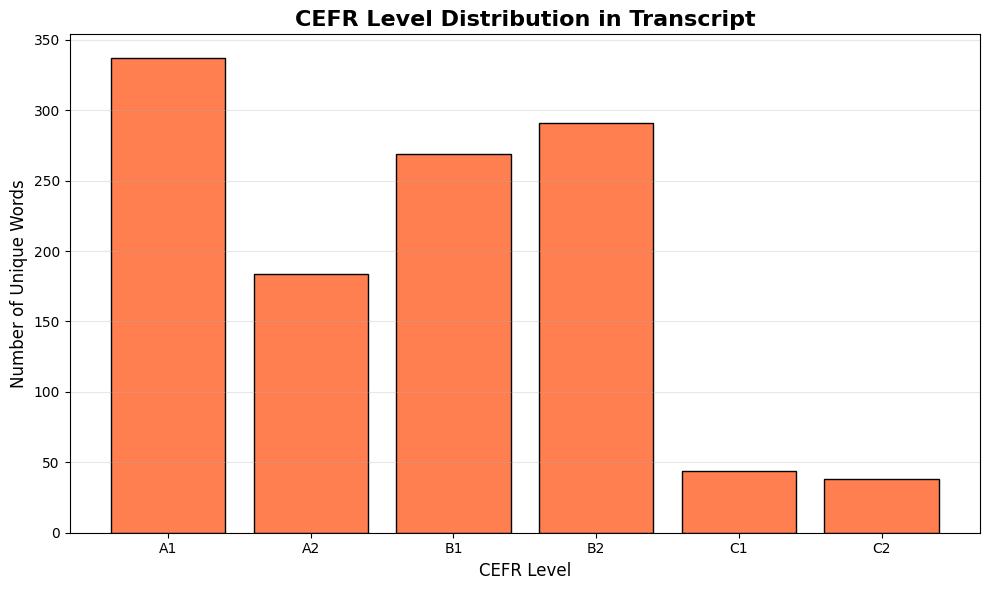

In [41]:
# Analyze CEFR distribution in transcript
level_counts = Counter([info['level'] for info in word_annotations.values()])
total_unique = len(word_annotations)

print("="*60)
print("CEFR LEVEL DISTRIBUTION IN TRANSCRIPT")
print("="*60)
print(f"\n{'Level':<10} {'Count':<10} {'Percentage'}")
print("-"*40)
for level in ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']:
    count = level_counts.get(level, 0)
    pct = (count / total_unique * 100) if total_unique > 0 else 0
    print(f"{level:<10} {count:<10} {pct:>6.2f}%")

print(f"\nTotal unique words: {total_unique}")

# Visualize distribution
plt.figure(figsize=(10, 6))
levels = ['A1', 'A2', 'B1', 'B2', 'C1', 'C2']
counts = [level_counts.get(level, 0) for level in levels]
plt.bar(levels, counts, color='coral', edgecolor='black')
plt.title('CEFR Level Distribution in Transcript', fontsize=16, fontweight='bold')
plt.xlabel('CEFR Level', fontsize=12)
plt.ylabel('Number of Unique Words', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [45]:
# Filter words at B2 level and above
advanced_levels = ['B2', 'C1', 'C2']
advanced_words = {
    word: info for word, info in word_annotations.items()
    if info['level'] in advanced_levels
}

print(f"Total advanced words (B2, C1, C2): {len(advanced_words)}")
print(f"\nBreakdown by level:")
for level in advanced_levels:
    count = sum(1 for w, i in advanced_words.items() if i['level'] == level)
    print(f"  {level}: {count} words")

# Sort by frequency to prioritize common words
advanced_words_sorted = sorted(
    advanced_words.items(),
    key=lambda x: word_freq.get(x[0], 0),
    reverse=True
)

print(f"\nTop 10 most frequent advanced words:")
for word, info in advanced_words_sorted[:10]:
    freq = word_freq.get(word, 0)
    print(f"  {word}: {info['level']} (appears {freq} times)")

Total advanced words (B2, C1, C2): 373

Breakdown by level:
  B2: 291 words
  C1: 44 words
  C2: 38 words

Top 10 most frequent advanced words:
  margin: B2 (appears 63 times)
  with: C1 (appears 54 times)
  will: B2 (appears 49 times)
  algorithm: B2 (appears 45 times)
  actually: C2 (appears 44 times)
  equals: B2 (appears 38 times)
  classifier: B2 (appears 35 times)
  spam: B2 (appears 33 times)
  learning: B2 (appears 31 times)
  vector: B2 (appears 30 times)


In [47]:
# Install requests if needed (uncomment if not installed)
# !pip install requests

import requests
import time
from typing import Optional, Dict

def get_word_definition(word: str) -> Optional[Dict]:
    """
    Fetch word definition from Free Dictionary API
    API: https://dictionaryapi.dev/
    """
    try:
        url = f"https://api.dictionaryapi.dev/api/v2/entries/en/{word}"
        response = requests.get(url, timeout=5)

        if response.status_code == 200:
            data = response.json()
            if data and len(data) > 0:
                entry = data[0]

                # Extract first meaning
                meanings = entry.get('meanings', [])
                if meanings:
                    first_meaning = meanings[0]
                    part_of_speech = first_meaning.get('partOfSpeech', 'unknown')
                    definitions = first_meaning.get('definitions', [])

                    if definitions:
                        definition = definitions[0].get('definition', 'No definition available')
                        example = definitions[0].get('example', '')

                        return {
                            'word': word,
                            'part_of_speech': part_of_speech,
                            'definition': definition,
                            'example': example,
                            'phonetic': entry.get('phonetic', '')
                        }
        return None
    except Exception as e:
        print(f"Error fetching definition for '{word}': {e}")
        return None

print("Dictionary API function defined.")

Dictionary API function defined.


In [48]:
# Fetch definitions for advanced words
# Note: This may take a while depending on the number of words
# We'll add a small delay between requests to be respectful to the API

print("Fetching definitions for advanced words...")
print("(This may take a few minutes depending on the number of words)\n")

word_definitions = {}
total_words = len(advanced_words)
success_count = 0
fail_count = 0

# Process words in batches with progress updates
for idx, (word, info) in enumerate(advanced_words_sorted, 1):
    # Show progress every 10 words
    if idx % 10 == 0:
        print(f"Progress: {idx}/{total_words} words processed...")

    definition_data = get_word_definition(word)

    if definition_data:
        word_definitions[word] = {
            **info,  # Include CEFR level and confidence
            'frequency': word_freq.get(word, 0),
            **definition_data  # Add definition data
        }
        success_count += 1
    else:
        # Store without definition
        word_definitions[word] = {
            **info,
            'frequency': word_freq.get(word, 0),
            'definition': 'Definition not available',
            'part_of_speech': 'N/A',
            'example': '',
            'phonetic': ''
        }
        fail_count += 1

    # Small delay to avoid overwhelming the API
    time.sleep(0.1)

print(f"\n✓ Definition fetching complete!")
print(f"  Successfully retrieved: {success_count}")
print(f"  Not found: {fail_count}")
print(f"  Total processed: {total_words}")

Fetching definitions for advanced words...
(This may take a few minutes depending on the number of words)

Progress: 10/373 words processed...
Progress: 20/373 words processed...
Progress: 30/373 words processed...
Progress: 40/373 words processed...
Progress: 50/373 words processed...
Progress: 60/373 words processed...
Progress: 70/373 words processed...
Progress: 80/373 words processed...
Progress: 90/373 words processed...
Progress: 100/373 words processed...
Progress: 110/373 words processed...
Progress: 120/373 words processed...
Progress: 130/373 words processed...
Progress: 140/373 words processed...
Progress: 150/373 words processed...
Progress: 160/373 words processed...
Progress: 170/373 words processed...
Progress: 180/373 words processed...
Progress: 190/373 words processed...
Progress: 200/373 words processed...
Progress: 210/373 words processed...
Progress: 220/373 words processed...
Progress: 230/373 words processed...
Progress: 240/373 words processed...
Progress: 250/

In [49]:
# Export advanced words with definitions to CSV
definitions_df = pd.DataFrame([
    {
        'word': word,
        'cefr_level': data['level'],
        'frequency': data['frequency'],
        'confidence': data['confidence'],
        'part_of_speech': data.get('part_of_speech', 'N/A'),
        'phonetic': data.get('phonetic', ''),
        'definition': data.get('definition', ''),
        'example': data.get('example', '')
    }
    for word, data in word_definitions.items()
])

# Sort by frequency
definitions_df = definitions_df.sort_values('frequency', ascending=False)

# Save to CSV
definitions_filename = 'advanced_words_with_definitions.csv'
definitions_df.to_csv(definitions_filename, index=False)

print(f"✓ Advanced words with definitions saved to '{definitions_filename}'")
print(f"\nDataset summary:")
print(f"  Total words: {len(definitions_df)}")
print(f"  Words with definitions: {len(definitions_df[definitions_df['definition'] != 'Definition not available'])}")
print(f"  Words without definitions: {len(definitions_df[definitions_df['definition'] == 'Definition not available'])}")
print(f"\nPreview of exported data:")
print(definitions_df.head(10))

✓ Advanced words with definitions saved to 'advanced_words_with_definitions.csv'

Dataset summary:
  Total words: 373
  Words with definitions: 359
  Words without definitions: 14

Preview of exported data:
         word cefr_level  frequency  confidence part_of_speech      phonetic  \
0      margin         B2         63   -0.452974           noun    /ˈmɑːdʒɪn/   
1        with         C1         54   -0.885040         adverb                 
2        will         B2         49    0.594079           verb         /wɪl/   
3   algorithm         B2         45    1.569337           noun  /ˈælɡəɹɪðm̩/   
4    actually         C2         44   -0.436908         adverb          /-ɪ/   
5      equals         B2         38   -0.102464           noun    /ˈiːkwəlz/   
6  classifier         B2         35   -0.788248           noun  /ˈklæsɪfaɪə/   
7        spam         B2         33    0.777377           noun       /ˈspæm/   
8    learning         B2         31   -0.235927           verb     /ˈlɜːn

In [50]:
# Create a vocabulary learning summary
print("="*80)
print("VOCABULARY LEARNING SUMMARY")
print("="*80)

# Statistics by level
print("\nAdvanced Vocabulary Statistics:")
print(f"{'Level':<10} {'Total Words':<15} {'With Definitions':<20} {'Most Frequent'}")
print("-"*80)

for level in ['B2', 'C1', 'C2']:
    level_words = definitions_df[definitions_df['cefr_level'] == level]
    total = len(level_words)
    with_def = len(level_words[level_words['definition'] != 'Definition not available'])

    # Get most frequent word at this level
    if total > 0:
        most_freq_word = level_words.iloc[0]['word']
        most_freq_count = level_words.iloc[0]['frequency']
        most_frequent = f"{most_freq_word} ({most_freq_count}x)"
    else:
        most_frequent = "N/A"

    print(f"{level:<10} {total:<15} {with_def:<20} {most_frequent}")

print("\n" + "="*80)
print("RECOMMENDATION FOR VOCABULARY LEARNING:")
print("="*80)
print("""
1. Start with B2 words - these are upper-intermediate level
2. Focus on high-frequency words first (they appear often in the text)
3. Use the provided examples to understand context
4. Move to C1 and C2 words as you master B2 vocabulary

The exported CSV file contains all advanced words with:
- CEFR level classification
- Frequency in your transcript
- Dictionary definitions and examples
- Part of speech information
""")

VOCABULARY LEARNING SUMMARY

Advanced Vocabulary Statistics:
Level      Total Words     With Definitions     Most Frequent
--------------------------------------------------------------------------------
B2         291             283                  margin (63x)
C1         44              42                   with (54x)
C2         38              34                   actually (44x)

RECOMMENDATION FOR VOCABULARY LEARNING:

1. Start with B2 words - these are upper-intermediate level
2. Focus on high-frequency words first (they appear often in the text)
3. Use the provided examples to understand context
4. Move to C1 and C2 words as you master B2 vocabulary

The exported CSV file contains all advanced words with:
- CEFR level classification
- Frequency in your transcript
- Dictionary definitions and examples
- Part of speech information



In [51]:
# Group words by CEFR level with definitions
print("="*80)
print("ADVANCED WORDS GROUPED BY LEVEL WITH DEFINITIONS")
print("="*80)

for level in ['B2', 'C1', 'C2']:
    words_at_level = {w: d for w, d in word_definitions.items() if d['level'] == level}

    # Sort by frequency
    sorted_words = sorted(words_at_level.items(), key=lambda x: x[1]['frequency'], reverse=True)

    print(f"\n{level} Level ({len(words_at_level)} words)")
    print("="*80)

    # Show top 10 words for each level
    for idx, (word, data) in enumerate(sorted_words[:10], 1):
        print(f"\n{idx}. {word.upper()} (appears {data['frequency']} times)")
        print(f"   {data['part_of_speech']}: {data['definition'][:150]}...")
        if data['example']:
            print(f"   Example: \"{data['example'][:100]}...\"")

    if len(words_at_level) > 10:
        print(f"\n   ... and {len(words_at_level) - 10} more {level} words")

ADVANCED WORDS GROUPED BY LEVEL WITH DEFINITIONS

B2 Level (291 words)

1. MARGIN (appears 63 times)
   noun: The edge of the paper, typically left blank when printing but sometimes used for annotations etc....

2. WILL (appears 49 times)
   verb: (now uncommon or literary) To wish, desire (something)....
   Example: "Do what you will...."

3. ALGORITHM (appears 45 times)
   noun: A collection of ordered steps that solve a mathematical problem. A precise step-by-step plan for a computational procedure that possibly begins with a...

4. EQUALS (appears 38 times)
   noun: A person or thing of equal status to others....
   Example: "This beer has no equal...."

5. CLASSIFIER (appears 35 times)
   noun: Someone who classifies....

6. SPAM (appears 33 times)
   noun: (rarely countable) Unsolicited bulk electronic messages....
   Example: "I get far too much spam...."

7. LEARNING (appears 31 times)
   verb: To acquire, or attempt to acquire knowledge or an ability to do something....

8. VE

In [52]:
# Display sample definitions
print("="*80)
print("SAMPLE ADVANCED WORDS WITH DEFINITIONS")
print("="*80)

# Show first 15 words with definitions
sample_count = 0
for word, data in word_definitions.items():
    if sample_count >= 15:
        break
    if data['definition'] != 'Definition not available':
        print(f"\nWord: {word.upper()}")
        print(f"  CEFR Level: {data['level']}")
        print(f"  Frequency in text: {data['frequency']}")
        print(f"  Part of Speech: {data['part_of_speech']}")
        if data['phonetic']:
            print(f"  Pronunciation: {data['phonetic']}")
        print(f"  Definition: {data['definition']}")
        if data['example']:
            print(f"  Example: \"{data['example']}\"")
        print("-" * 80)
        sample_count += 1

SAMPLE ADVANCED WORDS WITH DEFINITIONS

Word: MARGIN
  CEFR Level: B2
  Frequency in text: 63
  Part of Speech: noun
  Pronunciation: /ˈmɑːdʒɪn/
  Definition: The edge of the paper, typically left blank when printing but sometimes used for annotations etc.
--------------------------------------------------------------------------------

Word: WITH
  CEFR Level: C1
  Frequency in text: 54
  Part of Speech: adverb
  Definition: Along, together with others, in a group, etc.
  Example: "Do you want to come with?"
--------------------------------------------------------------------------------

Word: WILL
  CEFR Level: B2
  Frequency in text: 49
  Part of Speech: verb
  Pronunciation: /wɪl/
  Definition: (now uncommon or literary) To wish, desire (something).
  Example: "Do what you will."
--------------------------------------------------------------------------------

Word: ALGORITHM
  CEFR Level: B2
  Frequency in text: 45
  Part of Speech: noun
  Pronunciation: /ˈælɡəɹɪðm̩/
  Definition